In [17]:
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

print('TF version:', tf.__version__)
print('TFP version:', tfp.__version__)

TF version: 2.1.0
TFP version: 0.9.0


In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import RMSprop
import os
import numpy as np
import matplotlib.pyplot as plt


In [9]:
# Load the HAR dataset and create some data processing functions

# Function to load the data from file
def load_HAR_data():
    data_dir = 'data/HAR/'
    x_train = np.load(os.path.join(data_dir, 'x_train.npy'))[..., :6]
    y_train = np.load(os.path.join(data_dir, 'y_train.npy')) - 1
    x_test  = np.load(os.path.join(data_dir, 'x_test.npy'))[..., :6]
    y_test  = np.load(os.path.join(data_dir, 'y_test.npy')) - 1
    return (x_train, y_train), (x_test, y_test)

# Dictionary containing the labels and the associated activities
label_to_activity = {0: 'walking horizontally', 1: 'walking upstairs', 2: 'walking downstairs',
                     3: 'sitting', 4: 'standing', 5: 'laying'}

# Function to change integer labels to one-hot labels
def integer_to_onehot(data_integer):
    data_onehot = np.zeros(shape=(data_integer.shape[0], data_integer.max()+1))
    for row in range(data_integer.shape[0]):
        integer = int(data_integer[row])
        data_onehot[row, integer] = 1
    return data_onehot

# Load the data
(x_train, y_train), (x_test, y_test) = load_HAR_data()
y_train_oh = integer_to_onehot(y_train)
y_test_oh = integer_to_onehot(y_test)

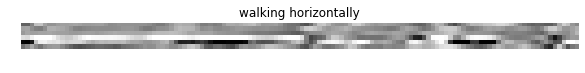

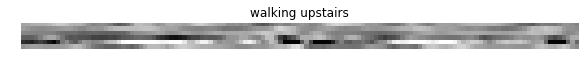

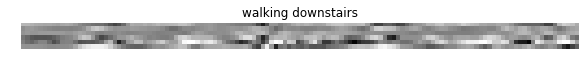

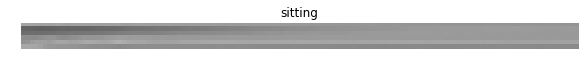

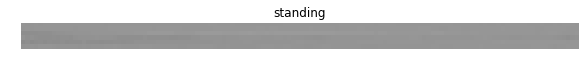

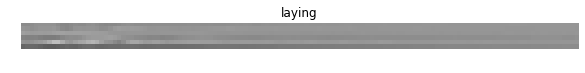

In [12]:
# Inspect some of the data by making plots

def make_plots(num_examples_per_category):
    for label in range(6):
        x_label = x_train[y_train[:, 0] == label]
        for i in range(num_examples_per_category):
            fig, ax = plt.subplots(figsize=(10, 1))
            ax.imshow(x_label[100*i].T, cmap='Greys', vmin=-1, vmax=1)
            ax.axis('off')
            if i == 0:
                ax.set_title(label_to_activity[label])
            plt.show()
        
make_plots(1)

In [15]:
x_train.shape

(7352, 128, 6)

In [13]:
# Create standard deterministic model with:
# - Conv1D
# - MaxPooling
# - Flatten
# - Dense with Softmax

model = Sequential([
    Conv1D(input_shape=(128, 6), filters=8, kernel_size=16, activation='relu'),
    MaxPooling1D(pool_size=16),
    Flatten(),
    Dense(units=6, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 113, 8)            776       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 8)              0         
_________________________________________________________________
flatten (Flatten)            (None, 56)                0         
_________________________________________________________________
dense (Dense)                (None, 6)                 342       
Total params: 1,118
Trainable params: 1,118
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Create probablistic model with the following layers:
#  - Conv1D
#  - MaxPooling
#  - Flatten
#  - Dense
#  - OneHotCategorical

divergence_fn= lambda q,p,_:tfd.kl_divergence(q,p)/x_train.shape[0]
model= Sequential([tfpl.Convolution1DReparameterization(input_shape=(128,6),filters=8,kernel_size=16,activation='relu',
                                          kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                                          kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                          kernel_divergence_fn=divergence_fn,
                                          bias_prior_fn=tfpl.default_multivariate_normal_fn,
                                          bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                          bias_divergence_fn=divergence_fn),
                  MaxPooling1D(pool_size=16),
                  Flatten(),
                  tfpl.DenseReparameterization(units=tfpl.OneHotCategorical.params_size(6),activation=None,
                                          kernel_prior_fn=tfpl.default_multivariate_normal_fn,
                                          kernel_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                          kernel_divergence_fn=divergence_fn,
                                          bias_prior_fn=tfpl.default_multivariate_normal_fn,
                                          bias_posterior_fn=tfpl.default_mean_field_normal_fn(is_singular=False),
                                          bias_divergence_fn=divergence_fn),
                  tfpl.OneHotCategorical(6)])


model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_reparameterization_4  (None, 113, 8)            1552      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 7, 8)              0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 56)                0         
_________________________________________________________________
dense_reparameterization (De (None, 6)                 684       
_________________________________________________________________
one_hot_categorical (OneHotC ((None, 6), (None, 6))    0         
Total params: 2,236
Trainable params: 2,236
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Replace analytical Kullback-Leibler divergence with approximated one

def kl_approx(q, p, q_tensor):
    return tf.reduce_mean(q.log_prob(q_tensor) - p.log_prob(q_tensor))

divergence_fn = lambda q, p, q_tensor : kl_approx(q, p, q_tensor) / x_train.shape[0]

In [30]:
# Compile the model using the negative loglikelihood

def nll(y_true, y_pred):
    return -y_pred.log_prob(y_true)

model.compile(loss=nll,
              optimizer=RMSprop(learning_rate=0.005),
              metrics=['accuracy'],
              experimental_run_tf_function=False)

In [31]:
# Train the model

model.fit(x_train, y_train_oh, epochs=20, verbose=False)
model.evaluate(x_train, y_train_oh)
model.evaluate(x_test, y_test_oh)

2947/2947 [==============================] - 1s 204us/sample - loss: 0.9503 - accuracy: 0.7180


[0.950260258743348, 0.71801835]

In [37]:
# Define function to analyse model predictions versus true labels

def analyse_model_predictions(image_num):

    # Show the accelerometer data
    print('------------------------------')
    print('Accelerometer data:')
    fig, ax = plt.subplots(figsize=(10, 1))
    ax.imshow(x_test[image_num].T, cmap='Greys', vmin=-1, vmax=1)
    ax.axis('off')
    plt.show()

    # Print the true activity
    print('------------------------------')
    print('True activity:', label_to_activity[y_test[image_num, 0]])
    print('')

    # Print the probabilities the model assigns
    print('------------------------------')
    print('Model estimated probabilities:')
    # Create ensemble of predicted probabilities
    predicted_probabilities = np.empty(shape=(200, 6))
    for i in range(200):
        predicted_probabilities[i] = model(x_test[image_num][np.newaxis, ...]).mean().numpy()[0]

    pct_2p5 = np.array([np.percentile(predicted_probabilities[:, i], 2.5) for i in range(6)])
    pct_97p5 = np.array([np.percentile(predicted_probabilities[:, i], 97.5) for i in range(6)])
    # Make the plots
    fig, ax = plt.subplots(figsize=(9, 3))
    bar = ax.bar(np.arange(6), pct_97p5, color='red')
    bar[y_test[image_num, 0]].set_color('green')
    bar = ax.bar(np.arange(6), pct_2p5-0.02, color='white', linewidth=1, edgecolor='white')
    ax.set_xticklabels([''] + [activity for activity in label_to_activity.values()],
                       rotation=45, horizontalalignment='right')
    ax.set_ylim([0, 1])
    ax.set_ylabel('Probability')
    plt.show()

------------------------------
Accelerometer data:


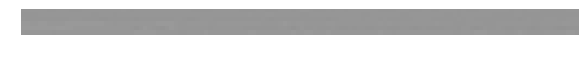

------------------------------
True activity: laying

------------------------------
Model estimated probabilities:
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)
(6,)

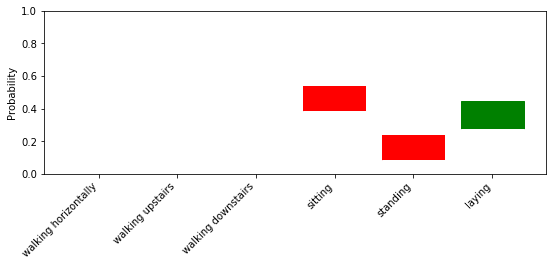

In [38]:
analyse_model_predictions(58)